In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import random
import re
from torchvision import  utils
from torch.utils.data import Dataset
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage

In [2]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224), scale = (0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [3]:
batchsize = 10
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [4]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample

In [5]:
trainset = CovidCTDataset(root_dir='COVID-CT/Images-processed',
                          txt_COVID='COVID-CT/Data-split/COVID/trainCT_COVID.txt',
                          txt_NonCOVID='COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir='COVID-CT/Images-processed',
                          txt_COVID='COVID-CT/Data-split/COVID/valCT_COVID.txt',
                          txt_NonCOVID='COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir='COVID-CT/Images-processed',
                          txt_COVID='COVID-CT/Data-split/COVID/testCT_COVID.txt',
                          txt_NonCOVID='COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)
print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())


train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

425
118
203


In [6]:
print(trainset.__getitem__(0)['img'].size())

torch.Size([3, 224, 224])


1


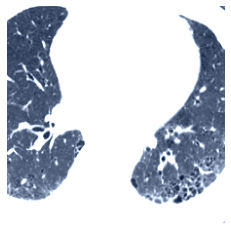

In [7]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h


x = trainset.__getitem__(400)['img']
label = trainset.__getitem__(400)['label']
myimshow(x)
print(label)

In [8]:
alpha = None
device = 'cuda'
def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#        data = data[:, 0, :, :]
#        data = data[:, None, :, :]
#         data, targets_a, targets_b, lam = mixup_data(data, target.long(), alpha, use_cuda=True)
        
        
        optimizer.zero_grad()
        output = model(data)
        
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)
        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    #f = open('model_result/{}.txt'.format(modelname), 'a+')
    #f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        #100.0 * train_correct / len(train_loader.dataset)))
    #f.write('\n')
    #f.close()


In [9]:
def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#            data = data[:, 0, :, :]
#            data = data[:, None, :, :]
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
          
    return targetlist, scorelist, predlist

In [10]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#            data = data[:, 0, :, :]
#            data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist

In [11]:
import torchvision.models as models
model = models.densenet169(pretrained=False).cuda()
modelname = 'Dense169'

In [12]:
import torchvision.models as models
model = models.resnet18(pretrained=False).cuda()
modelname = 'ResNet18'

In [13]:
import torchvision.models as models
model = models.densenet121(pretrained=False).cuda()
modelname = 'Dense121'

In [14]:
import torchvision.models as models
model = models.resnet50(pretrained=False).cuda()
modelname = 'ResNet50'

In [15]:
import torchvision.models as models
model = models.vgg16(pretrained=False)
model = model.cuda()
modelname = 'vgg16'

In [16]:
bs = 10
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#scheduler = StepLR(optimizer, step_size=1)

total_epoch = 1
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        p_list.append(p)
        r_list.append(r)
        acc_list.append(acc)
        AUC_list.append(AUC)
        
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), "{}.pt".format(modelname))  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

        #f = open('model_result/{}.txt'.format(modelname), 'a+')
        #f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        #epoch, r, p, F1, acc, AUC))
        #f.close()

Train Epoch: 1 [0/43 (0%)]	Train Loss: 0.696062
Train Epoch: 1 [10/43 (23%)]	Train Loss: 0.092405
Train Epoch: 1 [20/43 (47%)]	Train Loss: 0.066821
Train Epoch: 1 [30/43 (70%)]	Train Loss: 0.094909
Train Epoch: 1 [40/43 (93%)]	Train Loss: 0.069520

Train set: Average loss: 0.1247, Accuracy: 204/425 (48%)

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.58117741 0.56239051 0.55182213 0.57170361 0.56933641 0.57568598
 0.55875683 0.5710597  0.58056813 0.56966323 0.56407493 0.56609708
 0.56564355 0.56864095 0.57694179 0.57518351 0.57328391 0.54849756
 0.55853587 0.55807316 0.56118321 0.55219841 0.55494094 0.5589149
 0.55459422 0.55773169 0.55683351 0.55945224 0.562058

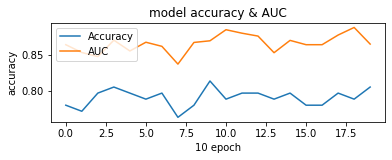

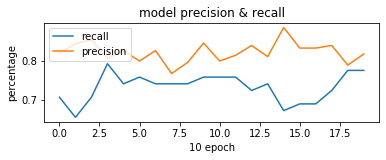

In [17]:
bs = 10
import warnings
warnings.filterwarnings('ignore')

r_list1 = []
p_list1 = []
acc_list1 = []
AUC_list1 = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 1
for epoch in range(1, total_epoch+1):
    
    targetlist, scorelist, predlist = test(epoch)
#     print('target',targetlist)
#     print('score',scorelist)
#     print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 
    
    TP = ((predlist == 1) & (targetlist == 1)).sum()
    TN = ((predlist == 0) & (targetlist == 0)).sum()
    FN = ((predlist == 0) & (targetlist == 1)).sum()
    FP = ((predlist == 1) & (targetlist == 0)).sum()

    print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
    print('TP+FP',TP+FP)
    p = TP / (TP + FP)
    print('precision',p)
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    print('recall',r)
    F1 = 2 * r * p / (r + p)
    acc = (TP + TN) / (TP + TN + FP + FN)
    print('F1',F1)
    print('acc',acc)
    AUC = roc_auc_score(targetlist, vote_score)
    print('AUC', AUC)
    p_list1.append(p)
    r_list1.append(r)
    acc_list1.append(acc)
    AUC_list1.append(AUC)
    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        
#         print('vote_pred', vote_pred)
#         print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUC', AUC)

        
#         f = open('model_result/{modelname}.txt', 'a+')
#         f.write('precision, recall, F1, acc= \n')
#         f.writelines(str(p))
#         f.writelines('\n')
#         f.writelines(str(r))
#         f.writelines('\n')
#         f.writelines(str(F1))
#         f.writelines('\n')
#         f.writelines(str(acc))
#         f.writelines('\n')
#         f.close()
        
        
        vote_pred = np.zeros((1,testset.__len__()))
        vote_score = np.zeros(testset.__len__())
        print('vote_pred',vote_pred)
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

TP= 105 TN= 0 FN= 0 FP= 98
TP+FP 203
precision 0.5172413793103449
recall 1.0
F1 0.6818181818181819
acc 0.5172413793103449
AUC 0.3985908649173956


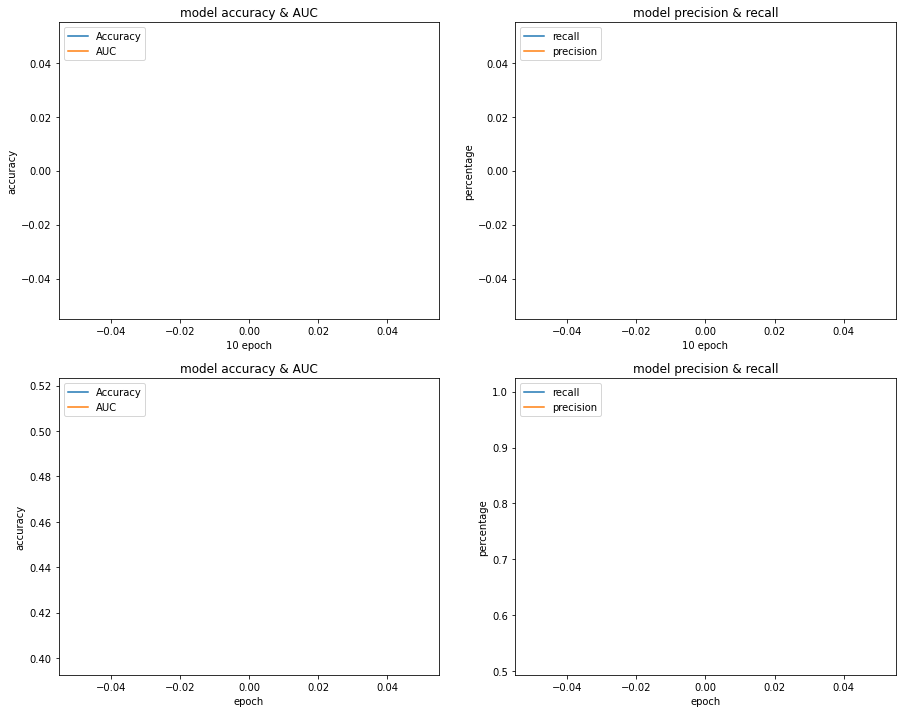

In [18]:
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.plot(acc_list)
plt.plot(AUC_list)
plt.title('model accuracy & AUC')
plt.ylabel('accuracy')
plt.xlabel('10 epoch')
plt.legend(['Accuracy', 'AUC'], loc='upper left')
#plt.show()
#### Fill in plot ####


#Plot loss vs epoch
plt.subplot(222)
plt.plot(r_list)
plt.plot(p_list)
plt.title('model precision & recall')
plt.ylabel('percentage')
plt.xlabel('10 epoch')
plt.legend(['recall', 'precision'], loc='upper left')
#plt.show()


plt.subplot(223)
plt.plot(acc_list1)
plt.plot(AUC_list1)
plt.title('model accuracy & AUC')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'AUC'], loc='upper left')
#plt.show()
#### Fill in plot ####





#Plot loss vs epoch
plt.subplot(224)
plt.plot(r_list1)
plt.plot(p_list1)
plt.title('model precision & recall')
plt.ylabel('percentage')
plt.xlabel('epoch')
plt.legend(['recall', 'precision'], loc='upper left')
plt.show()